In [1]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from ast import literal_eval
from typing import List, Tuple
import os
import string
import sys
import torch
import torch.nn as nn
from scipy.spatial.distance import squareform, pdist, cdist
from Bio import SeqIO
from time import sleep
import esm
torch.set_grad_enabled(False)
from einops import rearrange
import gc

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Select the GPU to run on
cuda = torch.device('cuda:0')
torch.cuda.set_device(0)

In [3]:
df_rmsds = pd.read_csv('../data/rmsd_dataset.csv')

In [4]:
def get_query_tensor(query_path):
    query = torch.load(query_path)
    return query


def get_rmsd_label(df_rmsds, pdb_id):
    labels = literal_eval(df_rmsds[df_rmsds['Unnamed: 0'].str.contains(pdb_id[:4].lower())].iloc[0, 1])
    return labels


def normalize(data):
    #data = np.reshape(data, (1, len(data)))
    data = data - np.mean(data)
    data = data / np.std(data)
    return data


def display_heatmap(data, title):
    # Change the data to a numpy array
    data = np.array(data)

    # If the data is a 1D array, reshape it to 2D
    if len(data.shape) == 1:
        data = np.reshape(data, (1, len(data)))

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=10)
    plt.title(title)
    plt.show()


def display_lineplot(data_1, data_2, title):
    # Plot the lineplot
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.lineplot(data=data_1)
    sns.lineplot(data=data_2)
    plt.title(title)
    plt.show()

In [5]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)


def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    return sequence.translate(translation)


def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]


def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    """ Select sequences from the MSA to maximize the hamming distance.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]


def make_query_matrices(pdb_id, msa_directory='/home/vera/projects/masters_project/data/alignments/', sequence_count=128, start_index=0):

    msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
    msa_transformer = msa_transformer.eval().cuda()
    msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

    # Make sure the PDB ID is in the right format
    if len(pdb_id) == 5:
        pdb_id = pdb_id[:4] + '_' + pdb_id[4]

    msa_path = os.path.join(msa_directory, 'aligned_' + pdb_id + '.a3m')
    
    # Run MSA Transformer if the MSA input file exists and embeddings output file doesn't exist
    if not os.path.isfile(msa_path):
        print('ERROR: The MSA file "' + msa_path + '" does not exist!')
        return None
    
    torch.cuda.empty_cache()
    inputs = read_msa(msa_path)

    inputs = greedy_select(inputs, num_seqs=sequence_count)
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    
    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
    
    column_attentions = result['col_attentions'][0].cpu().numpy()
    query_row_heads = column_attentions[:, :, :, :, 0]
    query_col_heads = column_attentions[:, :, :, 0, :]
    # Flatten the first two dimensions into one
    query_row_heads = np.reshape(query_row_heads, (query_row_heads.shape[0] * query_row_heads.shape[1], query_row_heads.shape[2], query_row_heads.shape[3]))
    query_col_heads = np.reshape(query_col_heads, (query_col_heads.shape[0] * query_col_heads.shape[1], query_col_heads.shape[2], query_col_heads.shape[3]))
    query_heads = np.stack((query_row_heads, query_col_heads), axis=0)
    query_heads = np.swapaxes(query_heads, -1, -2)

    gc.collect()
    torch.cuda.empty_cache()
            
    return query_heads

In [6]:
DATA_PATH = '../data/query_col_attentions/'
query_attention_files = os.listdir(DATA_PATH)

df = pd.read_csv('../backup/data/cluster_ids_out.csv')

# Sort in descending order according to rmsd
df.sort_values(by='rmsd', ascending=False, inplace=True)
#top_names = df['pdb_id'].tolist()

existing_files = {}

# Iterate over every row in the dataframe
for index, row in df.iterrows():
    name = row['pdb_id']
    rmsd = row['rmsd']
    pdb_id = name[:4].lower() + '_' + name[4].lower()
    path = 'query_col_attentions_' + pdb_id + '_128.pt'

    if path in query_attention_files and df_rmsds['Unnamed: 0'].str.contains(pdb_id[:4].lower()).any():
        labels = labels = get_rmsd_label(df_rmsds, pdb_id)
        existing_files[pdb_id] = {
        "path": path,
        "rmsd": rmsd,
        "labels": labels
    }

print(len(df))
print(len(existing_files))

38341
5622


In [216]:
pdb = '6tjf_a'
query_matrix = make_query_matrices('6tjf_a', sequence_count=64)[:, :, :, 1:]
labels = normalize(existing_files[pdb]['labels'])

print(query_matrix.shape)
print(len(labels))

(2, 144, 64, 245)
(2, 144, 64, 244)
244


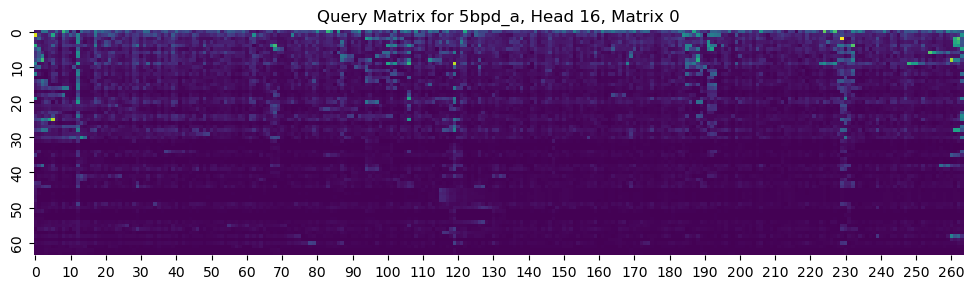

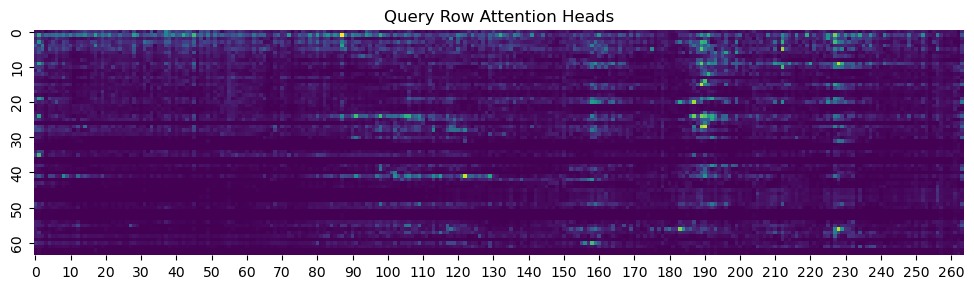

In [352]:
display_heatmap(query_matrix[0, 16, :, :], f'Query Matrix for {pdb}, Head {16}, Matrix {0}')
display_heatmap(query_matrix[0, 143, :, :], 'Query Row Attention Heads')

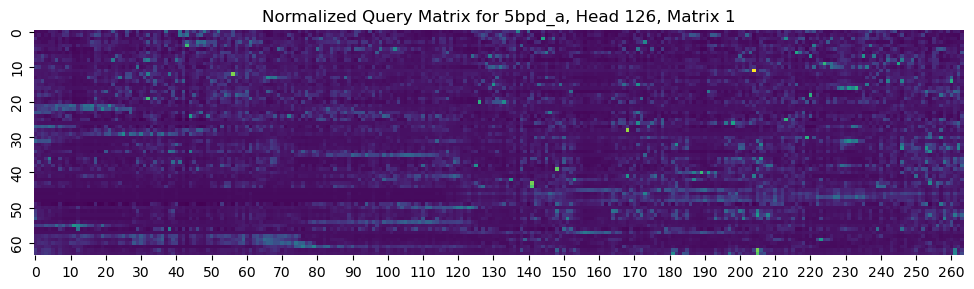

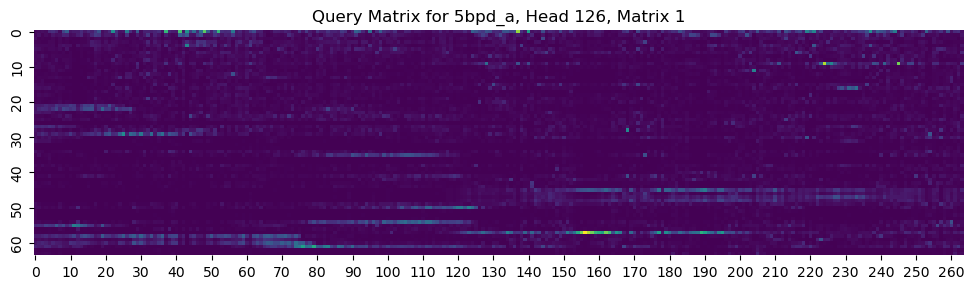

In [79]:
pdb = '6tjf_a'
pdb = '5bpd_a'
pdb = '5fog_d'
pdb = '4rq8_a'
pdb = '5bpd_a'
# pdb = '1ay1_h'
# pdb = '2qke_e'
# pdb = '4mvd_b'


query_matrix = make_query_matrices(pdb, sequence_count=64)[:, :, :, 1:]


MATRIX_NUM = 1
heads = [50, 118, 133, 137, 142, 100]
heads = [84, 100]
heads = [126]

for head in heads:
    test = query_matrix[MATRIX_NUM, head, :, :]
    mean = np.mean(test, axis=1, keepdims=True)
    std = np.std(test, axis=1, keepdims=True)
    norm_test = (test - mean) / std
    display_heatmap(norm_test, f'Normalized Query Matrix for {pdb}, Head {head}, Matrix {MATRIX_NUM}')
    display_heatmap(test, f'Query Matrix for {pdb}, Head {head}, Matrix {MATRIX_NUM}')

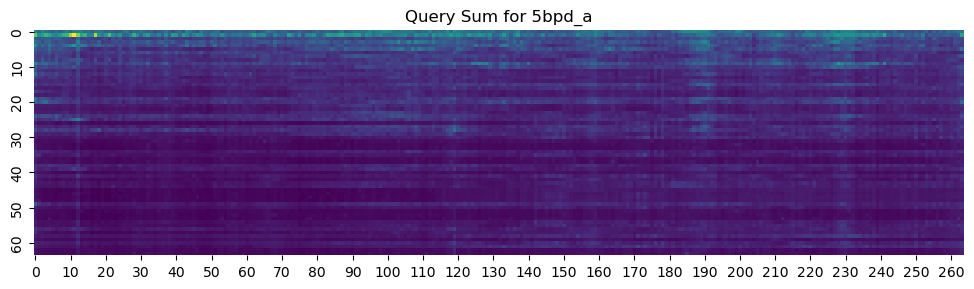

In [48]:
query_sum = np.sum(query_matrix[0], axis=(0))
query_sum_sum = np.sum(query_sum, axis=0)
display_heatmap(query_sum, f'Query Sum for {pdb}')


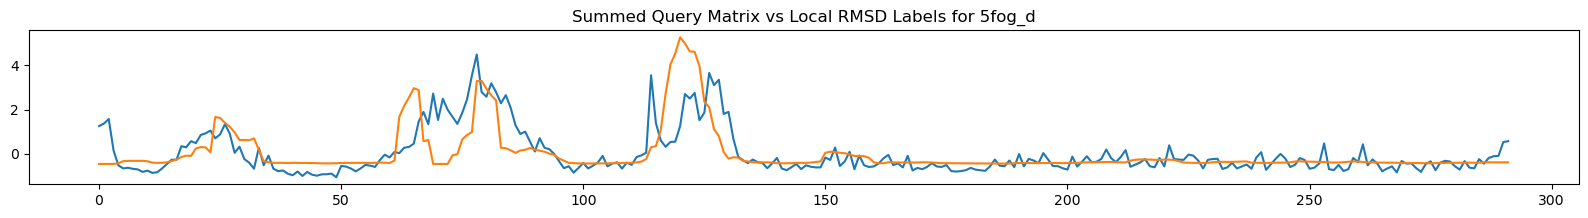

In [29]:
pdb = '6tjf_a'
pdb = '5bpd_a'
pdb = '5fog_d'
#pdb = '4rq8_a'
#pdb = '5bpd_a'
#pdb = '1c3h_a'

def display_lineplot(data_1, data_2, title):
    # Plot the lineplot
    fig, ax = plt.subplots(figsize=(20, 2))
    sns.lineplot(data=data_1)
    sns.lineplot(data=data_2)
    plt.title(title)
    plt.show()



query_matrix = make_query_matrices(pdb, sequence_count=64)[:, :, :, 1:]
labels = normalize(existing_files[pdb]['labels'])

sum_1 = np.sum(query_matrix[0, :, :, :], axis=(0, 1))
sum_1 = normalize(sum_1)

display_lineplot(sum_1, labels, f'Summed Query Matrix vs Local RMSD Labels for {pdb}')

(2, 144, 64, 333)


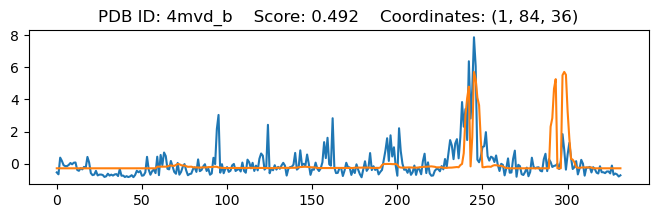

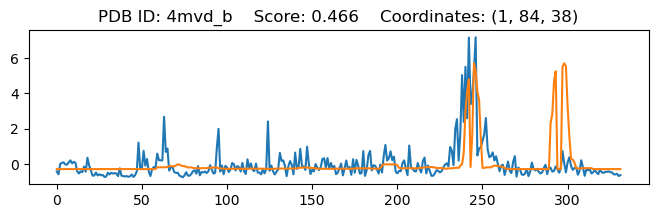

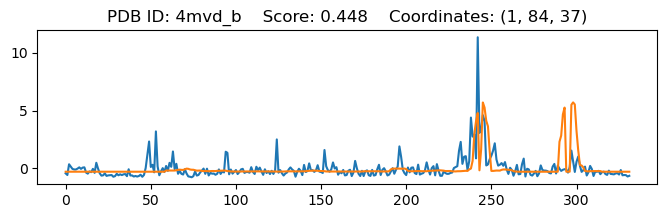

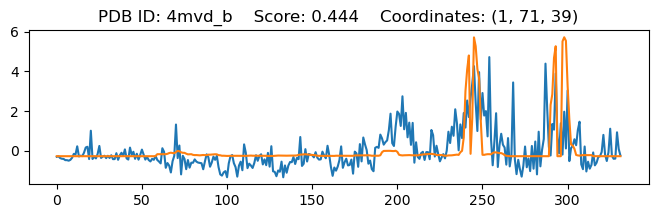

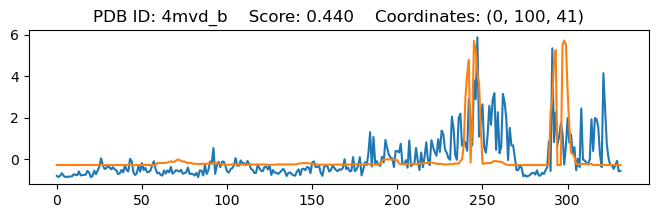

In [15]:
pdb = '6tjf_a'
pdb = '5bpd_a'
pdb = '5fog_d'
pdb = '4rq8_a'
pdb = '5bpd_a'
pdb = '4mvd_b'


query_matrix = make_query_matrices(pdb, sequence_count=64)[:, :, :, 1:]
labels = normalize(existing_files[pdb]['labels'])

summed_maps = np.sum(query_matrix, axis=1)
#display_heatmap(summed_maps[0, :, :], 'Query Row Attention Heads')

dataset = query_matrix.reshape(-1, query_matrix.shape[-1])

# Normalize the dataset
mean_per_sequence = np.mean(dataset, axis=1, keepdims=True)
std_per_sequence = np.std(dataset, axis=1, keepdims=True)
norm_dataset = (dataset - mean_per_sequence) / std_per_sequence
norm_labels = normalize(labels)
scores = []
for seq in norm_dataset:
    corrcoef = np.corrcoef(seq, norm_labels)[0, 1]
    scores.append(corrcoef)
# Get the index of the highest correlation coefficient
indices = np.argsort(scores)[::-1]

for index in indices[:5]:
    most_similar_sequence = norm_dataset[index]
    most_similar_coordinates = np.unravel_index(index, query_matrix.shape[:-1])
    title = f'PDB ID: {pdb}    Score: {scores[index]:.3f}    Coordinates: {most_similar_coordinates}'
    display_lineplot(most_similar_sequence, norm_labels, title)

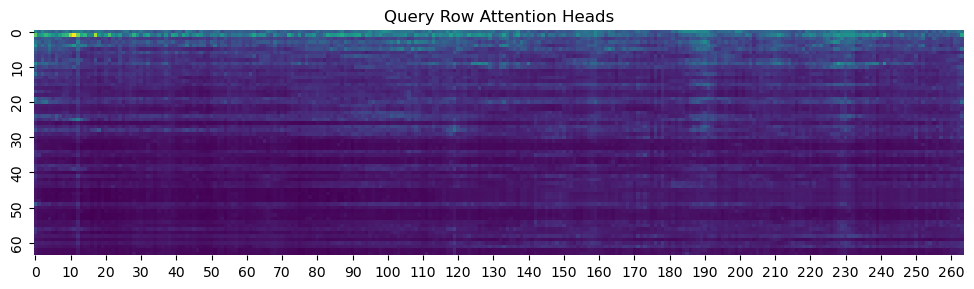

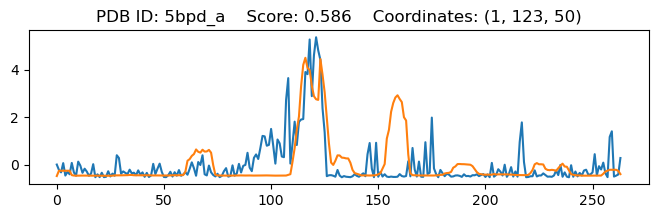

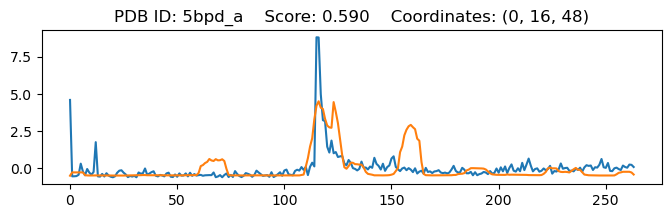

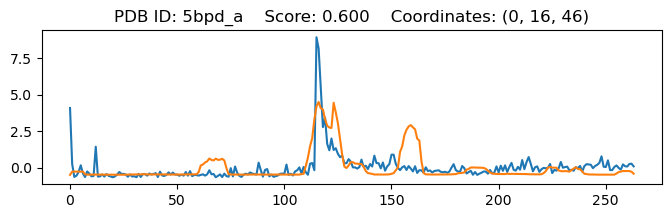

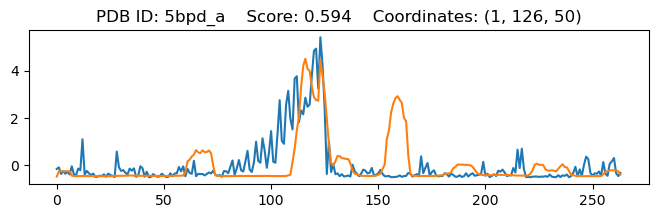

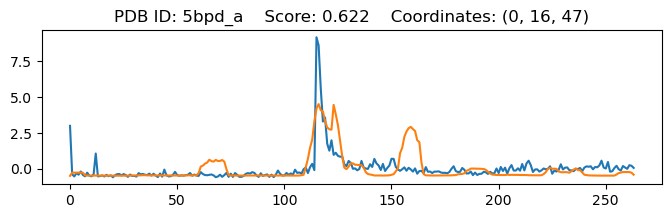

In [75]:
pdb = '6tjf_a'
pdb = '5fog_d'
pdb = '4rq8_a'
pdb = '5bpd_a'
#pdb = '4mvd_b'


query_matrix = make_query_matrices(pdb, sequence_count=64)[:, :, :, 1:]
labels = normalize(existing_files[pdb]['labels'])
summed_maps = np.sum(query_matrix, axis=1)
display_heatmap(summed_maps[0, :, :], 'Query Row Attention Heads')

#START_INDEX, END_INDEX = 140, -1
#START_INDEX, END_INDEX = 0, 140
#START_INDEX, END_INDEX = 0, -1
#query_matrix = query_matrix[:, :, :, START_INDEX:END_INDEX]
#labels = labels[START_INDEX:END_INDEX]


dataset = query_matrix.reshape(-1, query_matrix.shape[-1])

# Normalize the dataset
mean_per_sequence = np.mean(dataset, axis=1, keepdims=True)
std_per_sequence = np.std(dataset, axis=1, keepdims=True)
norm_dataset = (dataset - mean_per_sequence) / std_per_sequence
norm_labels = normalize(labels)

# Calculate the similarity scores
similarity_scores = cosine_similarity(norm_dataset, norm_labels.reshape(1, -1))

# Square the similarity scores to make them more pronounced
similarity_scores = similarity_scores

# Reshape the similarity scores into a matrix with the same shape as the query matrix
similarity_scores = similarity_scores.reshape(query_matrix.shape[:-1])

# Find the indices of the 5 highest similarity scores
indices = np.argpartition(similarity_scores.flatten(), -5)[-5:]
for index in indices:

    most_similar_sequence = norm_dataset[index]
    most_similar_coordinates = np.unravel_index(index, query_matrix.shape[:-1])
    score = similarity_scores[most_similar_coordinates]
    title = f'PDB ID: {pdb}    Score: {score:.3f}    Coordinates: {most_similar_coordinates}'
    display_lineplot(most_similar_sequence, norm_labels, title)

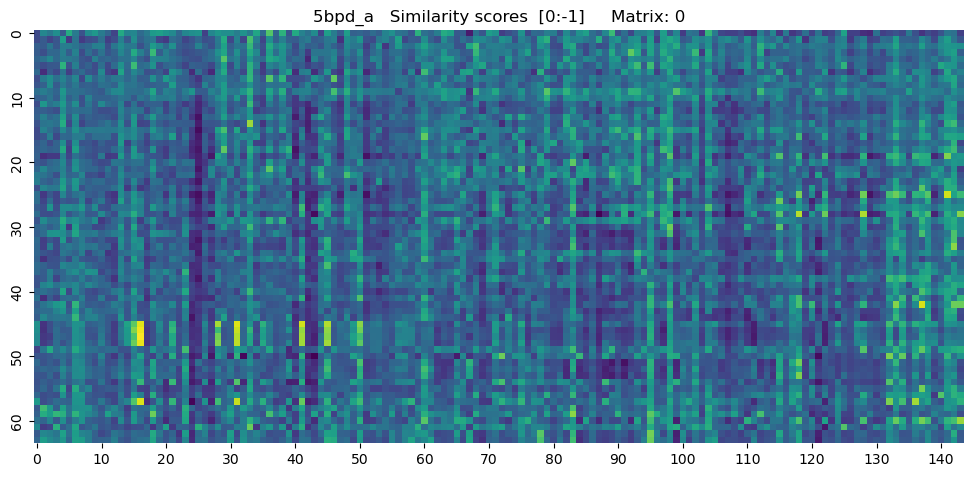

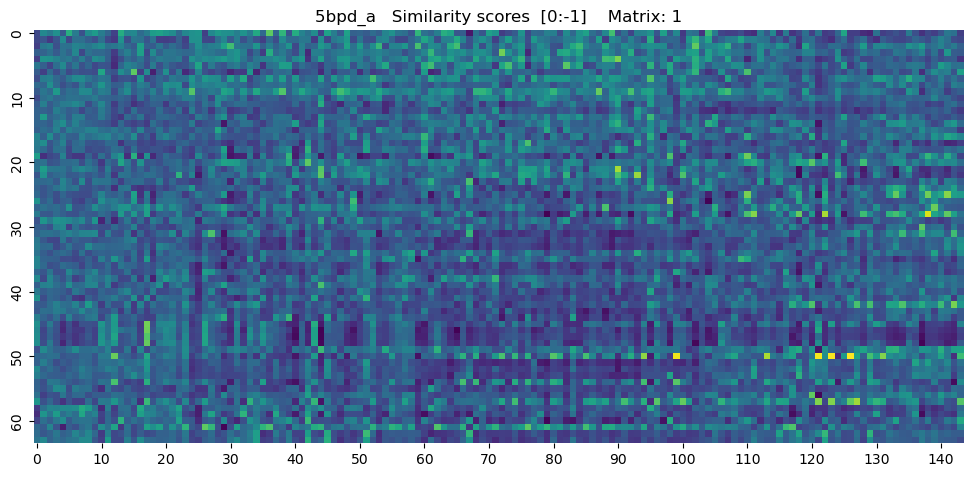

In [314]:
MATRIX_NUM = 0

display_heatmap(similarity_scores[0].T, f'{pdb}   Similarity scores  [{START_INDEX}:{END_INDEX}]     Matrix: 0')
display_heatmap(similarity_scores[1].T, f'{pdb}   Similarity scores  [{START_INDEX}:{END_INDEX}]    Matrix: 1')

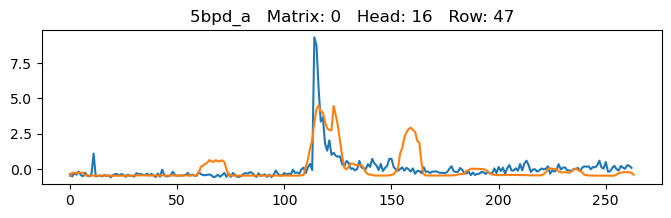

In [73]:
matrix_number = 0
head = 16
row = 47

activations = normalize(query_matrix[matrix_number, head, row, 1:])
labels = normalize(existing_files[pdb]['labels'])

display_lineplot(activations, labels, pdb + '   Matrix: ' + str(matrix_number) + '   Head: ' + str(head) + '   Row: ' + str(row))

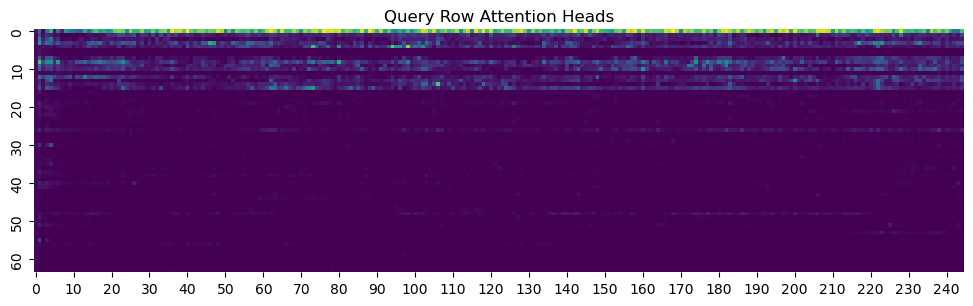

In [102]:
display_heatmap(query_matrix_6tjf_a[0, 136, :, :], 'Query Row Attention Heads')

In [76]:
display_heatmap(query_matrix_5bpd_a[1, 121, :, :], 'Query Row Attention Heads')

NameError: name 'query_matrix_5bpd_a' is not defined

In [159]:
DATA_PATH = '../data/query_col_attentions/'
query_attention_files = os.listdir(DATA_PATH)
query_attention_files[0]

'query_col_attentions_1nm3_b_128.pt'

(128, 343)
343


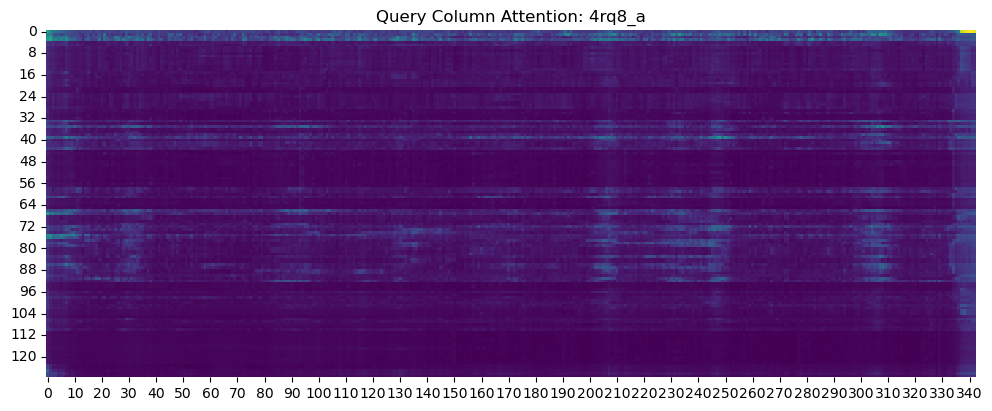

In [167]:
PDB = "4rq8_a"

path = 'query_col_attentions_' + PDB + '_128.pt'
tensor = get_query_tensor(DATA_PATH + path)[1,:,1:]
labels = get_rmsd_label(df_rmsds, PDB)
print(tensor.shape)
print(len(labels))
display_heatmap(tensor, 'Query Column Attention: ' + PDB)

In [57]:
START_INDEX = 0
NUM_PLOTS = 3

top_query_matrices = {}
for file, rmsd in existing_files[START_INDEX:START_INDEX + NUM_PLOTS]:
    pdb_id = file.split('query_col_attentions_')[-1].split('_128.pt')[0]
    labels = get_rmsd_label(df_rmsds, pdb_id)
    tensor = get_query_tensor(DATA_PATH + file)[1, :, 1:]
    tensor_sum = np.sum(tensor, axis=0)

    # Get the rmsd from the dataframe by using the pdb_id
    print(pdb_id)

    top_query_matrices[pdb_id] = {
        "tensor_sum": tensor_sum,
        "labels": labels,
        "rmsd": rmsd
    }
    tensor_sum = normalize(tensor_sum)
    labels = normalize(labels)
    display_lineplot(smooth(tensor_sum, 3), labels, pdb_id + '   RMSD:' + str(rmsd) + ' Å')
   

NameError: name 'existing_files' is not defined

In [96]:
DATA_PATH = '../data/query_col_attentions/'
query_attention_files = os.listdir(DATA_PATH)
# Shuffle the files

query_matrices = {}
for i, file in enumerate(query_attention_files):
    if i >= 5:
        break

    pdb_id = file.split('_')[3] + '_' + file.split('_')[4]
    labels = get_rmsd_label(df_rmsds, pdb_id)
    tensor = get_query_tensor(DATA_PATH + file)[1, :, 1:]
    tensor_sum = np.sum(tensor, axis=0)

    query_matrices[pdb_id] = {
        "tensor_sum": tensor_sum,
        "labels": labels
    }

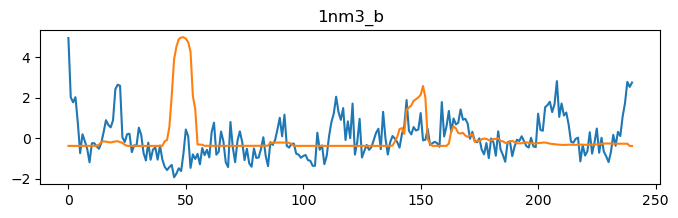

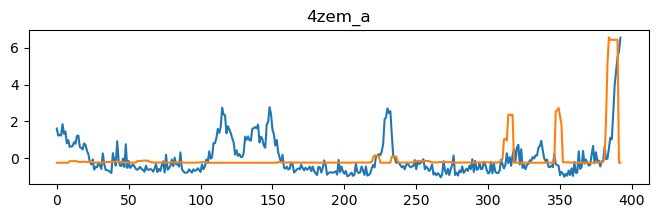

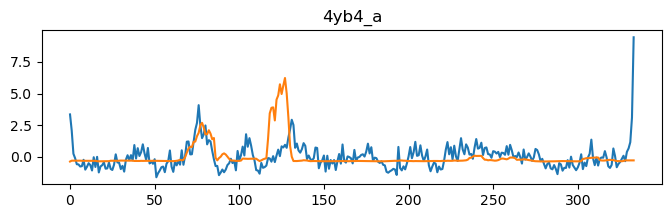

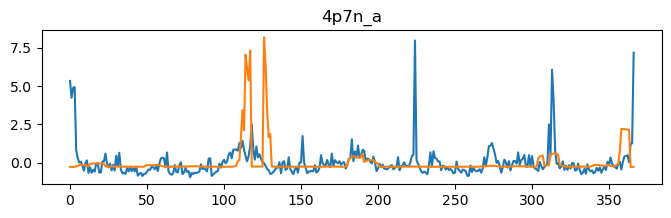

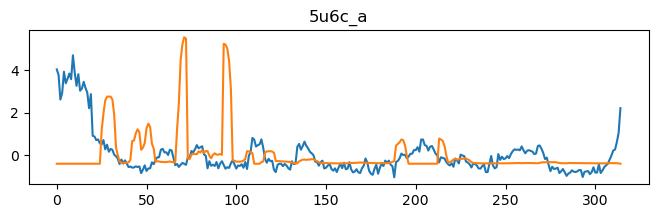

In [97]:
for pdb, info in query_matrices.items():
    tensor_sum = info["tensor_sum"]
    tensor_sum = normalize(tensor_sum)
    labels = info["labels"]
    labels = normalize(labels)
    display_lineplot(tensor_sum, labels, pdb)

## Experiments with combining similarity scores

In [364]:
# Iterate over the entries in the existing_files dictionary
i = 0
for pdb_id, info in existing_files.items():
    i += 1
    if i > 5:
        break
    rmsd = info["rmsd"]
    labels = info["labels"]
    print(pdb_id)
    print(rmsd)
    

4kmu_a
32.359
4q9u_a
28.094
4nzd_a
26.835
4xbz_c
25.103
2wqr_b
24.295


222

In [8]:


all_similarity_scoress = []
all_similarity_sums = []

# Reverse the order of the entries in the existing_files dictionary 
existing_files_reverse = dict(reversed(list(existing_files.items())))


for rmsd_set, set in [('top', existing_files), ('bottom', existing_files_reverse)]:
    
    similarity_scores_dict = {}
    similarity_scores_sum = np.zeros((2, 144, 64))

    i = 0
    for pdb, info in set.items():
        i += 1
        if i > 500:
            break
        if i % 25 == 0:
            print(i)
        
        labels = info["labels"]
        query_matrix = make_query_matrices(pdb, sequence_count=64)[:, :, :, 1:]

        if query_matrix.shape[-1] != len(labels):
            print('ERROR: The query matrix and labels are not the same length!')
            i -= 1
            continue

        dataset = query_matrix.reshape(-1, query_matrix.shape[-1])

        # Normalize the dataset
        mean_per_sequence = np.mean(dataset, axis=1, keepdims=True)
        std_per_sequence = np.std(dataset, axis=1, keepdims=True)
        norm_dataset = (dataset - mean_per_sequence) / std_per_sequence
        norm_labels = normalize(labels)

        # Calculate the similarity scores
        similarity_scores = cosine_similarity(norm_dataset, norm_labels.reshape(1, -1))

        # Reshape the similarity scores into a matrix with the same shape as the query matrix
        similarity_scores = similarity_scores.reshape(query_matrix.shape[:-1])
        
        similarity_scores_dict[pdb] = similarity_scores
        similarity_scores_sum += similarity_scores
    
    all_similarity_scoress.append(similarity_scores_dict)
    all_similarity_sums.append(similarity_scores_sum)


25
50
75
100
125
150
175
ERROR: The query matrix and labels are not the same length!
200
225
250
ERROR: The query matrix and labels are not the same length!
275
ERROR: The query matrix and labels are not the same length!
300
ERROR: The query matrix and labels are not the same length!
325
ERROR: The query matrix and labels are not the same length!
ERROR: The query matrix and labels are not the same length!
ERROR: The query matrix and labels are not the same length!
350
375
400
425
ERROR: The query matrix and labels are not the same length!
450
ERROR: The query matrix and labels are not the same length!
ERROR: The query matrix and labels are not the same length!
ERROR: The query matrix and labels are not the same length!
475
500
ERROR: The query matrix and labels are not the same length!
25
50
ERROR: The query matrix and labels are not the same length!
ERROR: The query matrix and labels are not the same length!
75
ERROR: The query matrix and labels are not the same length!
100
ERROR: The

In [10]:
total_sum = np.zeros((2, 144, 64))
for matrix in similarity_scores_dict.items()[:100]:
    print(matrix[1])
    total_sum += matrix[1]

TypeError: 'dict_items' object is not subscriptable

In [10]:
print(len(similarity_scores_dict.items()))

500


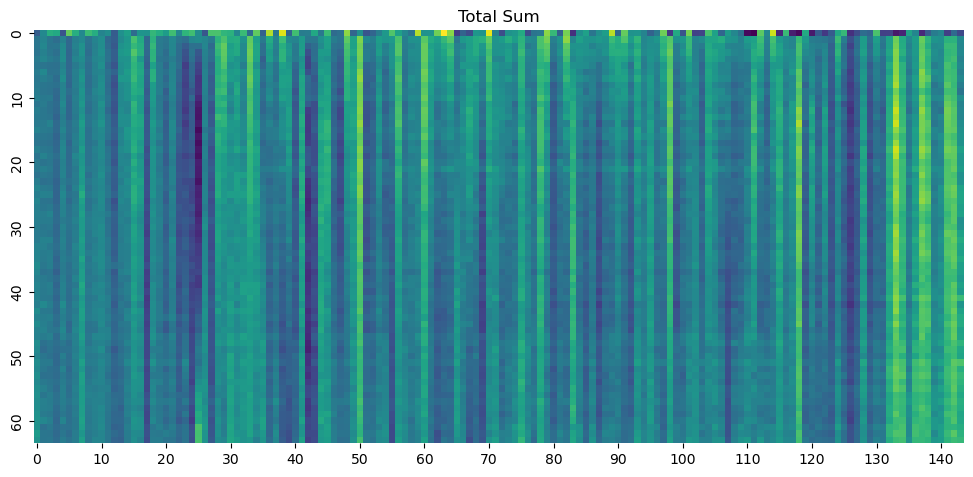

In [19]:
display_heatmap(all_similarity_sums[1][0].T, 'Total Sum')

In [32]:
top_similarity_score_sum = similarity_scores_sum
top_similarity_score_dict = similarity_scores_dict


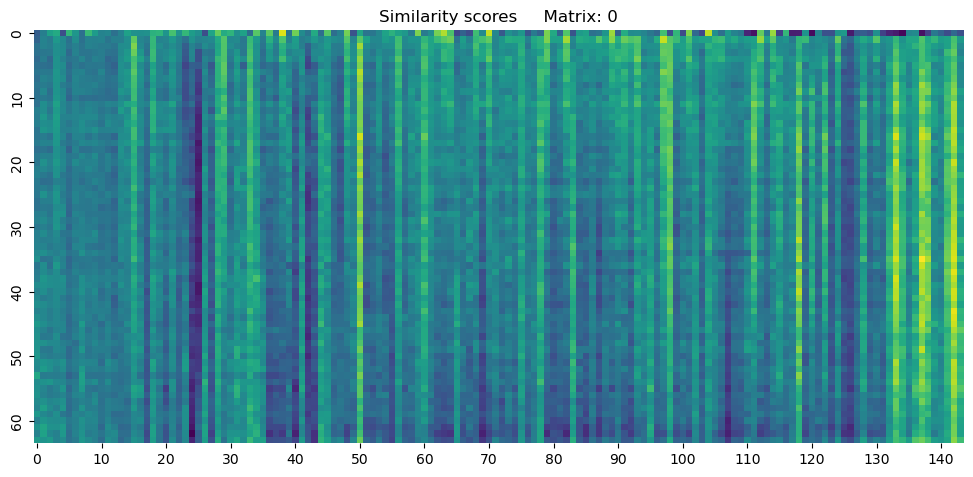

In [21]:
display_heatmap(similarity_scores_sum[0].T, f'Similarity scores     Matrix: 0')

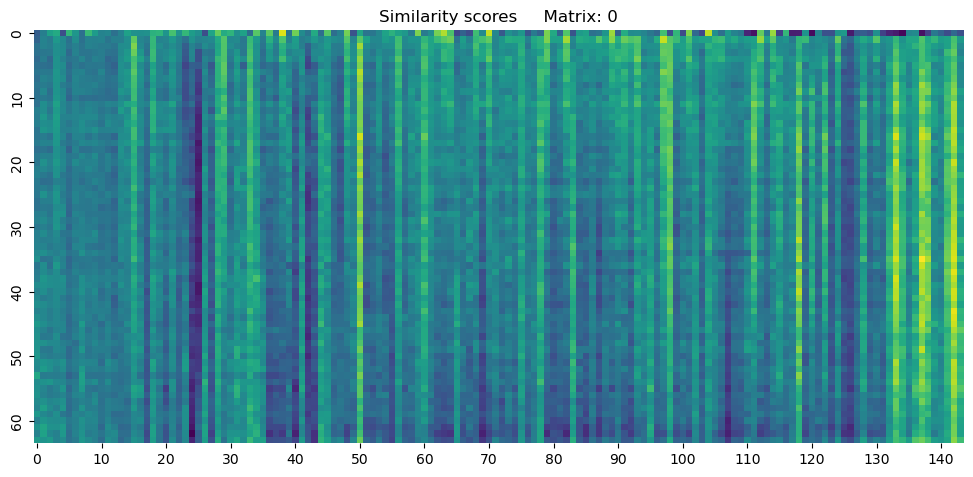

In [49]:
display_heatmap([0].T, f'Similarity scores     Matrix: 0')

In [29]:
print(similarity_scores_sum[0].shape)

(144, 64)


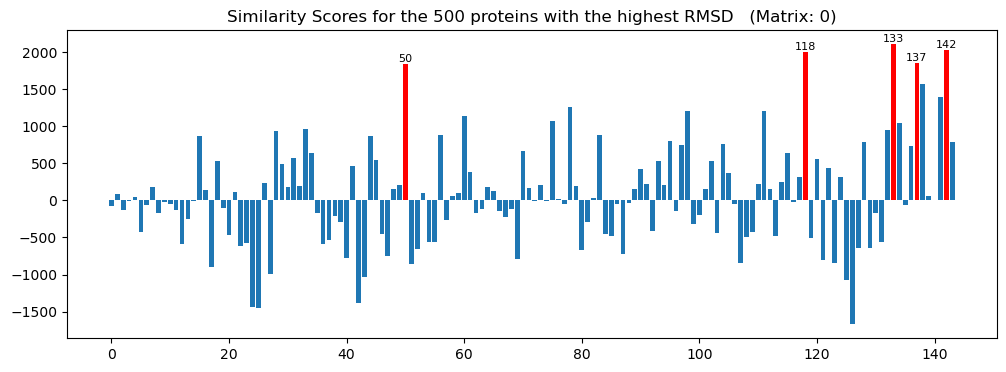

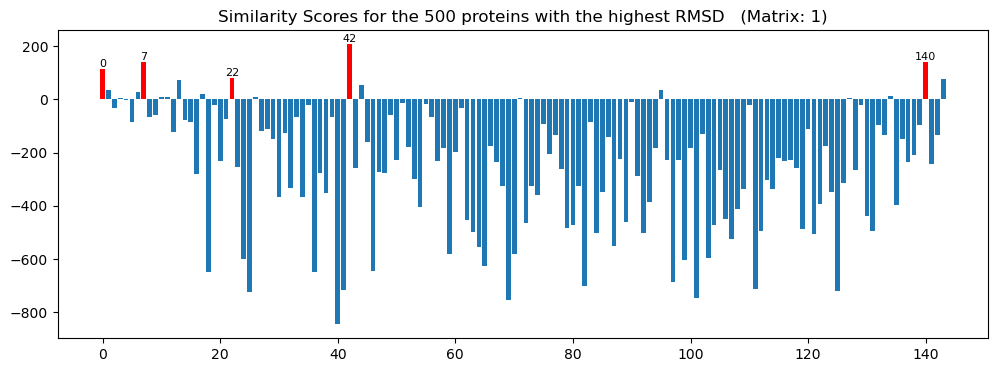

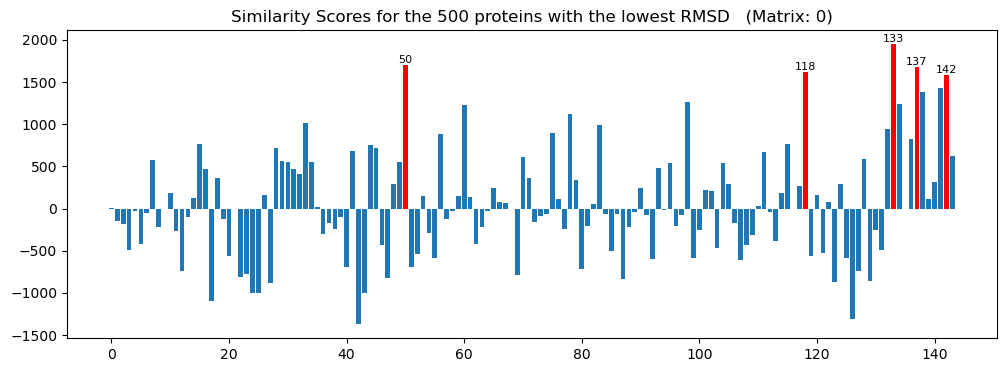

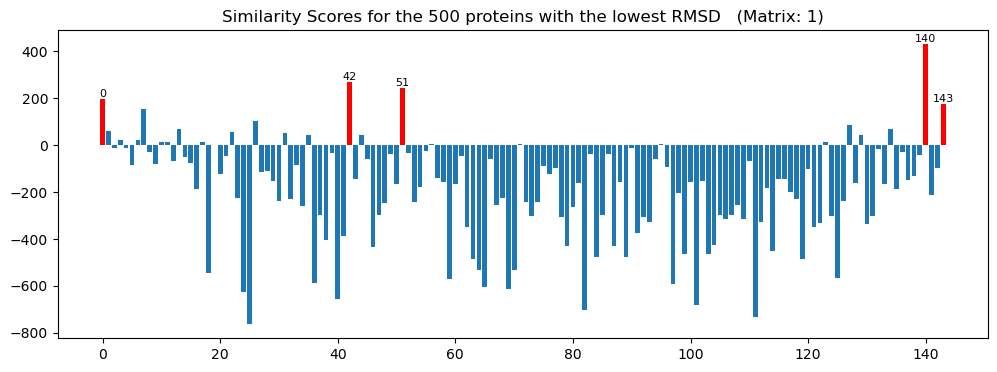

In [30]:


dict_length = len(similarity_scores_dict)
for rmsd_set, set in [('highest', all_similarity_sums[0]), ('lowest', all_similarity_sums[1])]:

    for MATRIX_NUM in range(2):
        similarity_scores_sum_sum = np.sum(set[MATRIX_NUM], axis=1)
        #display_heatmap(similarity_scores_sum_sum.T, f'Similarity scores     Matrix: {MATRIX_NUM}')

        # Identify the 5 highest similarity scores
        indices = np.argpartition(similarity_scores_sum_sum, -5)[-5:]

        # Plot a stacked bar chart of the similarity scores, with the 5 highest similarity scores highlighted with their x-coordinates on top of them
        fig, ax = plt.subplots(figsize=(12, 4))

        ax.bar(np.arange(144), similarity_scores_sum_sum)
        ax.bar(indices, similarity_scores_sum_sum[indices], color='red')
        for index in indices:
            ax.text(index, similarity_scores_sum_sum[index] + 0.01, str(index), fontsize=8, ha='center', va='bottom')


        plt.title(f'Similarity Scores for the {dict_length} proteins with the {rmsd_set} RMSD   (Matrix: {MATRIX_NUM})')
        plt.show()

## Get a list of the MSA sequences for a given pdb


In [30]:
def get_msa_seqs(pdb_id, sequence_count=64, msa_directory='/home/vera/projects/masters_project/data/alignments/'):

    msa_path = os.path.join(msa_directory, 'aligned_' + pdb_id + '.a3m')

    if not os.path.isfile(msa_path):
        print('ERROR: The MSA file "' + msa_path + '" does not exist!')
        return None
    
    inputs = read_msa(msa_path)
    inputs = greedy_select(inputs, num_seqs=sequence_count)
    return inputs

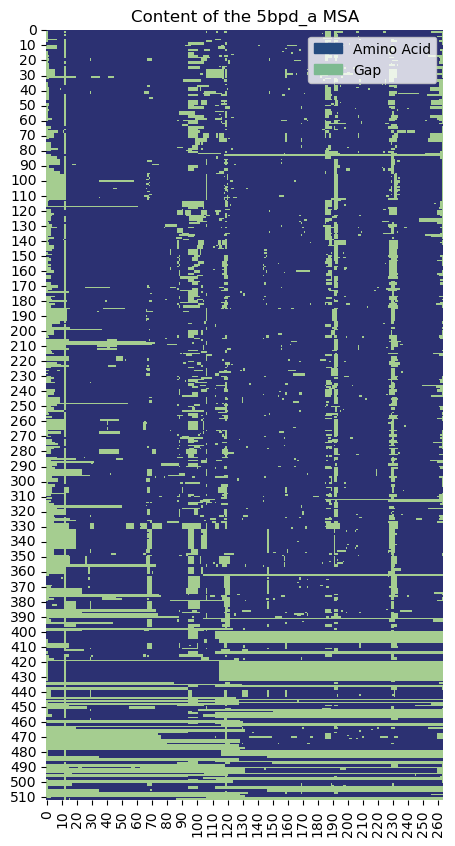

In [72]:
import matplotlib.patches as mpatches

seqs = get_msa_seqs('5bpd_a', sequence_count=512)
msa_matrix = np.zeros((len(seqs), len(seqs[0][1])))
for i in range(len(seqs)):
    # Convert the sequence to a numpy array where each element is either a 0 or 1 depending on whether the character is a gap or not
    msa_matrix[i] = np.array(list(seqs[i][1])) != '-'

# Display the MSA matrix as a heatmap using seaborn and a deep blue color palette
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(msa_matrix, cmap="crest", square=True, cbar=False, xticklabels=10, yticklabels=10)
# Set the colors in the legend to be the same as the extreme colors in the heatmap
ax.legend(handles=[mpatches.Patch(color='#254b7f', label='Amino Acid'), mpatches.Patch(color='#7dba91', label='Gap')])

plt.title('Content of the 5bpd_a MSA')
plt.show()

In [65]:
pal = sns.color_palette("crest")
pal.as_hex()[-1]

'#254b7f'